In [ ]:
import numpy as np
from functions import spec_hfilt2, medfilt_vertcal_norm, load_audiofile, locate_low_amp
import scipy.signal as signal
from scipy.signal import resample_poly, hilbert
import matplotlib.pyplot as plt

input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/001029.wav"
Fs  = 3000
Sx, Fs = load_audiofile(input_file,Fs, remove_offcet=True)

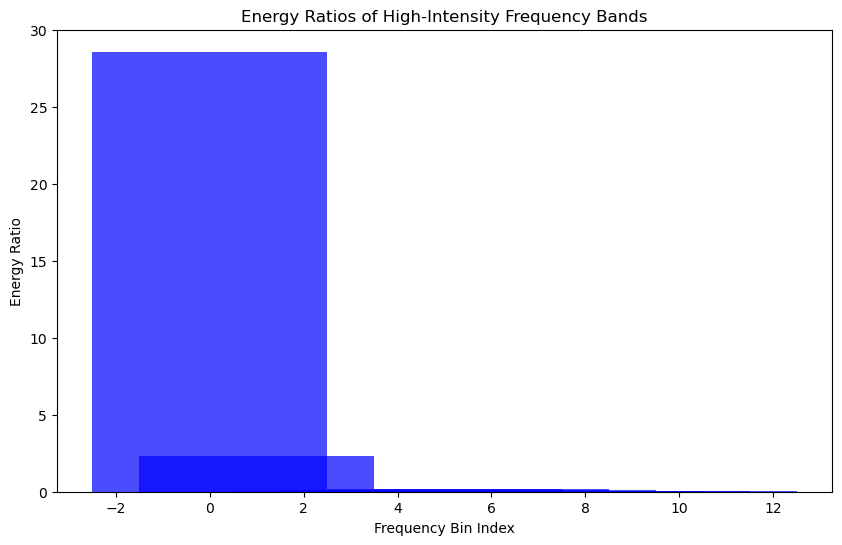

In [1]:
import numpy as np
import scipy.signal as signal
import scipy.io.wavfile as wav
import librosa
import librosa.display
import matplotlib.pyplot as plt

def compute_energy_ratio(audio_file, threshold_factor=1.5, neighbor_bandwidth=10):
    # Load audio file
    sr, audio = wav.read(audio_file)
    if audio.ndim > 1:
        audio = audio.mean(axis=1)  # Convert to mono if stereo
    
    # Compute STFT
    D = np.abs(librosa.stft(audio, n_fft=2048, hop_length=512))
    power_spectrum = np.mean(D**2, axis=1)  # Compute average power per frequency bin
    
    # Identify high-intensity frequencies
    avg_energy = np.mean(power_spectrum)
    high_intensity_indices = np.where(power_spectrum > threshold_factor * avg_energy)[0]
    
    energy_ratios = {}
    for idx in high_intensity_indices:
        band_energy = power_spectrum[idx]
        neighbor_indices = np.arange(max(0, idx - neighbor_bandwidth), min(len(power_spectrum), idx + neighbor_bandwidth))
        neighbor_energy = np.mean([power_spectrum[i] for i in neighbor_indices if i != idx])
        
        if neighbor_energy > 0:
            energy_ratios[idx] = band_energy / neighbor_energy
    
    return energy_ratios

def plot_energy_ratios(audio_file):
    ratios = compute_energy_ratio(audio_file)
    
    if not ratios:
        print("No high-intensity frequencies found.")
        return
    
    plt.figure(figsize=(10, 6))
    plt.bar(ratios.keys(), ratios.values(), width=5, color='b', alpha=0.7)
    plt.xlabel('Frequency Bin Index')
    plt.ylabel('Energy Ratio')
    plt.title('Energy Ratios of High-Intensity Frequency Bands')
    plt.show()

# Example usage
plot_energy_ratios('/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/001029.wav')